In [468]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 KB 766.4 kB/s eta 0:00:001m615.8 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [469]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import wilcoxon
from sklearn.cluster import KMeans
#import sklearn.cluster.hierarchical as hclust
from sklearn import preprocessing
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [131]:
import matplotlib.cm as cm
import matplotlib as matplotlib

def color_map_color(value, cmap_name='Wistia', vmin=0, vmax=1):
    # norm = plt.Normalize(vmin, vmax)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = matplotlib.colors.rgb2hex(rgb)
    return color

In [383]:
class AlgorithmComparisonData():
    def __init__(self, wins, significant_wins, defeats, significant_defeats):
        self.wins = wins
        self.significant_wins = significant_wins
        self.defeats = defeats
        self.significant_defeats = significant_defeats

    def __str__(self):
        return f"wins: {self.wins}({self.significant_wins})\ndefeats: {self.defeats}({self.significant_defeats})"

class ExperimentsDataAnalyzer():

    def __init__(self):
        self.data_lake = {}

    def load_data(self, data_source_name, data_source_path):
        df = pd.read_csv(data_source_path, sep=';')
        self.data_lake[data_source_name] = df

    def get_data_frame(self, data_source_name):
        return self.data_lake[data_source_name].copy()

    def compare(self, ref_alg_datasource_name, target_alg_datasource_name):
        ref_df = self.get_data_frame(ref_alg_datasource_name)
        tgt_df = self.get_data_frame(target_alg_datasource_name)
        
        wins, swins = 0, 0 
        defeats, sdefeats = 0, 0
    
        for i in range(len(tgt_df)):
            data1 = ref_df.iloc[i][1:]
            data2 = tgt_df.iloc[i][1:]
            
            d1_mean = np.mean(data1)
            d2_mean = np.mean(data2) 
        
            is_signif = False
            if d1_mean == 0.0 and d2_mean == 0.0:
                is_signif = False
            else:
                stat, p = wilcoxon(data1, data2, zero_method="zsplit", )
                if p <= 0.05:
                    is_signif = True
            
            if d1_mean > d2_mean:
                wins += 1
                if is_signif:
                    swins += 1
        
            elif d1_mean < d2_mean:
                defeats += 1
                if is_signif:
                    sdefeats += 1

        return AlgorithmComparisonData(wins, swins, defeats, sdefeats)

In [78]:
def get_x1_results(base_path, target_config):
    analyzer = ExperimentsDataAnalyzer()
    
    alg_ref_ds_name = "lshade_costs_by_seed"
    alg_ref_path = f"{base_path}/out(--lshade ).csv"

    alg_target_ds_name = "dmlshade_costs_by_seed"
    alg_target_path = f"{base_path}/out({target_config} ).csv"

    analyzer.load_data(alg_ref_ds_name, alg_ref_path)
    analyzer.load_data(alg_target_ds_name, alg_target_path)

    results = analyzer.compare(alg_ref_ds_name, alg_target_ds_name)

    return results

In [84]:
base_path = "~/code/FIM-CGRASP/results/stats_test_data/uv=10"
print(get_x1_results(base_path, "--dmlshade --crossgen --insert --k 36 --elsz 47 --dms 26"))

wins: 12(8)
defeats: 12(2)


In [132]:
base_path = "~/code/FIM-CGRASP/results/stats_test_data"
with open("algconfigs") as alg_configs:
    for config in alg_configs:
        print("Config: ", config)
        print(get_x1_results(base_path, config.replace("\n", "")))
        print("----")

Config:  --fimlshade --crossgen --elsz 126 --dms 9 --h 36 --s 44

wins: 14(3)
defeats: 10(1)
----
Config:  --fimlshade --crossgen --elsz 54 --dms 61 --h 5 --s 21

wins: 10(0)
defeats: 13(0)
----
Config:  --fimlshade --crossgen --elsz 150 --dms 18 --h 13 --s 42

wins: 14(2)
defeats: 10(0)
----
Config:  --fimlshade --crossgen --elsz 152 --dms 18 --h 13 --s 42
wins: 18(0)
defeats: 6(0)
----


In [384]:
analyzer = ExperimentsDataAnalyzer()

func_number = 5
base_path = f"~/code/FIM-CGRASP/results/generations/LSHADE/cec-f{func_number}/"

analyzer.load_data("pop-costs", base_path + "pop-costs.csv")

gens_count = 2163
pop_generations = {}
for i in range(gens_count):
    df_id = f"pop-g{i+1}"
    analyzer.load_data(df_id, base_path + f"{df_id}.csv")

<Axes: >

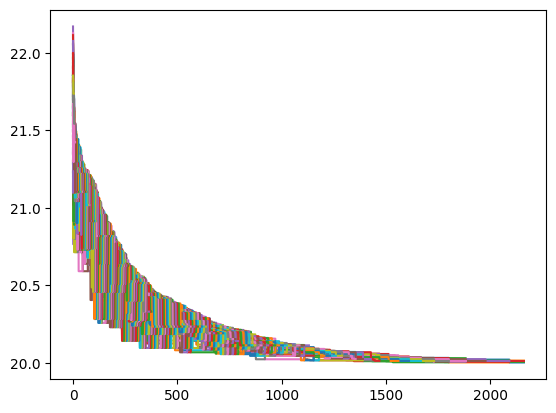

In [302]:
costs_df = analyzer.get_data_frame(f"pop-costs")
costs_df[costs_df != -1].plot(legend=False)

In [238]:
df = analyzer.get_data_frame(f"pop-g{1}")

fitness = costs_df[costs_df != -1].iloc[0]
fmin = 20
fmax = np.max(fitness)

In [239]:
sorted(fitness)[30]

21.4542

In [240]:
fitness.map(lambda x: "elite" if x < sorted(fitness)[30] else "common")

i1      common
i2       elite
i3      common
i4      common
i5      common
         ...  
i176    common
i177     elite
i178    common
i179    common
i180    common
Name: 0, Length: 180, dtype: object

In [454]:
def plot_pop_parallel_coordinates(gen_id):
    df = analyzer.get_data_frame(f"pop-g{gen_id}")
    
    fitness = costs_df[costs_df != -1].iloc[gen_id-1]
    #fmin = np.min(fitness)
    #fmax = np.max(fitness)

    colors = fitness.map(lambda x: color_map_color(x, cmap_name='bwr', vmin=fmin, vmax=fmax))
    elite = fitness.map(lambda x: "elite" if x < sorted(fitness)[30] else "common")

    df["class"] = range(1, len(df) + 1)
    pd.plotting.parallel_coordinates(df, 'class', color=colors)
    plt.gca().legend_.remove()

def plot_elite_parallel_coordinates(gen_id, elite_percent=0.3):
    df = analyzer.get_data_frame(f"pop-g{gen_id}")

    fitness = costs_df.iloc[gen_id-1]
    fitness = fitness[fitness > -1]

    elite = fitness[fitness != np.nan].map(lambda x: "elite" if x < sorted(fitness)[int(elite_percent * len(fitness))] else "common")

    df['class']  = list(elite)

    pd.plotting.parallel_coordinates(df[list(elite != 'common')], 'class', color=('blue', '#4ECDC4'))


def plot_pop_clusters_parallel_coordinates(gen_id,  k=4):
    df = analyzer.get_data_frame(f"pop-g{gen_id}")

    #k=4
    model = KMeans(n_clusters=k).fit(df)

    df["class"] = model.labels_

    pd.plotting.parallel_coordinates(df, 'class', colormap='tab20')
    plt.gca().legend_.remove()


def plot_elite_clusters_parallel_coordinates(gen_id, k=4):
    df = analyzer.get_data_frame(f"elite-g{gen_id}")

    
    model = KMeans(n_clusters=k).fit(df)

    df["class"] = model.labels_

    pd.plotting.parallel_coordinates(df, 'class', color=('red', 'green' , 'blue', 'black'))
    plt.gca().legend_.remove()

In [441]:
from ipywidgets import interact
import ipywidgets as widgets

interact(plot_pop_clusters_parallel_coordinates, gen_id=widgets.IntSlider(min=1, max=gens_count, step=1, value=1))



interactive(children=(IntSlider(value=1, description='gen_id', max=2163, min=1), IntSlider(value=4, descriptio…

<function __main__.plot_pop_clusters_parallel_coordinates(gen_id, k=4)>

In [429]:
_gen_id_ = 500
df = analyzer.get_data_frame(f"pop-g{_gen_id_}")

inertia = []
K = range(1,len(df))
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df)
    kmeanModel.fit(df)
    inertia.append(kmeanModel.inertia_)


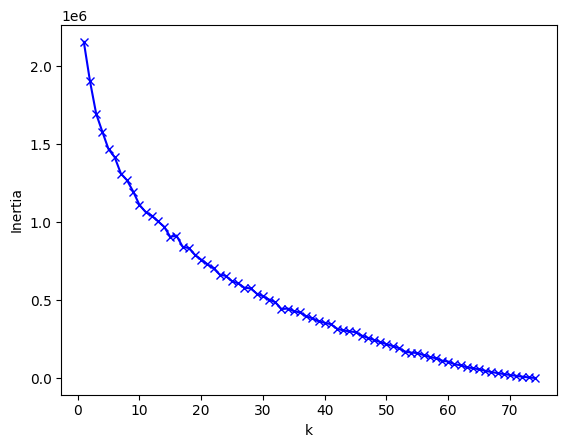

In [430]:
# Plot the elbow
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [393]:
kmeans = KMeans(n_clusters=4).fit(df)

In [395]:
kmeans.labels_

array([0, 1, 1, 1, 0, 1, 2, 3, 1, 3, 2, 1, 0, 1, 3, 3, 3, 0, 1, 0, 2, 3,
       1, 2, 3, 2, 1, 1, 3, 3, 3, 3, 3, 2, 3, 0, 3, 3, 2, 0, 2, 1, 3, 3,
       1, 0, 1, 3, 3, 2, 0, 1, 1, 2, 2, 2, 2, 1, 2, 3, 2, 2, 3, 2, 2, 0,
       3, 2, 3, 2, 0, 2, 0, 3, 2, 1, 3, 2, 1, 0, 2, 0, 2, 3, 0, 1, 2, 0,
       1, 0, 3, 0, 1, 2, 3, 2, 1, 3, 3, 0, 3, 3, 3, 3, 3, 0, 2, 2, 1, 1,
       0, 0, 0, 3, 2, 2, 2, 3, 3, 1, 2, 3, 2, 1, 0, 1, 2, 3, 3, 3, 0, 0,
       1, 0, 1, 2, 0, 3, 3, 3, 3, 3, 2, 1, 3, 2, 2, 0, 0, 3, 3, 3, 0, 0,
       0, 2, 3, 3, 0, 0, 1, 0, 0, 2, 2, 3, 3, 0, 3, 2, 3, 3, 1, 0, 3, 3,
       0, 1, 3, 2], dtype=int32)

### Analyze the elite data:

In [442]:
# Load elite data

func_number = 5
base_path = f"~/code/FIM-CGRASP/results/generations/DM_LSHADE/cec-f{func_number}/"

gens_count = 2163
pop_generations = {}
for i in range(gens_count):
    df_id = f"elite-g{i+1}"
    analyzer.load_data(df_id, base_path + f"{df_id}.csv")

In [490]:
gen_id = 15
elite_df = analyzer.get_data_frame(f"elite-g{gen_id}")

In [491]:
elite_df

inertia = []
K = range(1,len(elite_df))
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(elite_df)
    kmeanModel.fit(elite_df)
    inertia.append(kmeanModel.inertia_)

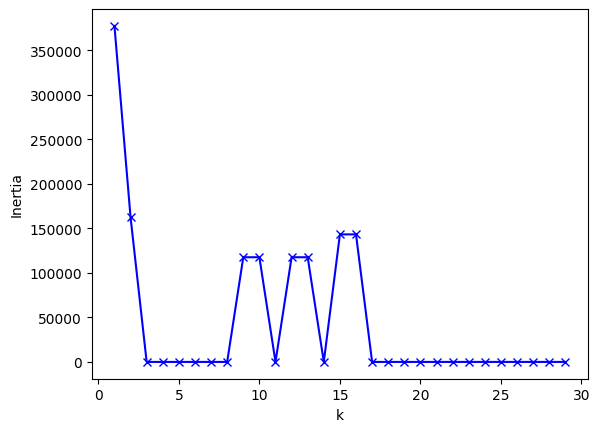

In [492]:
# Plot the elbow
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [455]:
interact(plot_elite_clusters_parallel_coordinates, gen_id=widgets.IntSlider(min=1, max=gens_count, step=1, value=1))

interactive(children=(IntSlider(value=1, description='gen_id', max=2163, min=1), IntSlider(value=4, descriptio…

<function __main__.plot_elite_clusters_parallel_coordinates(gen_id, k=4)>

In [ ]:
gen_id = 3
elite_df = analyzer.get_data_frame(f"elite-g{gen_id}")

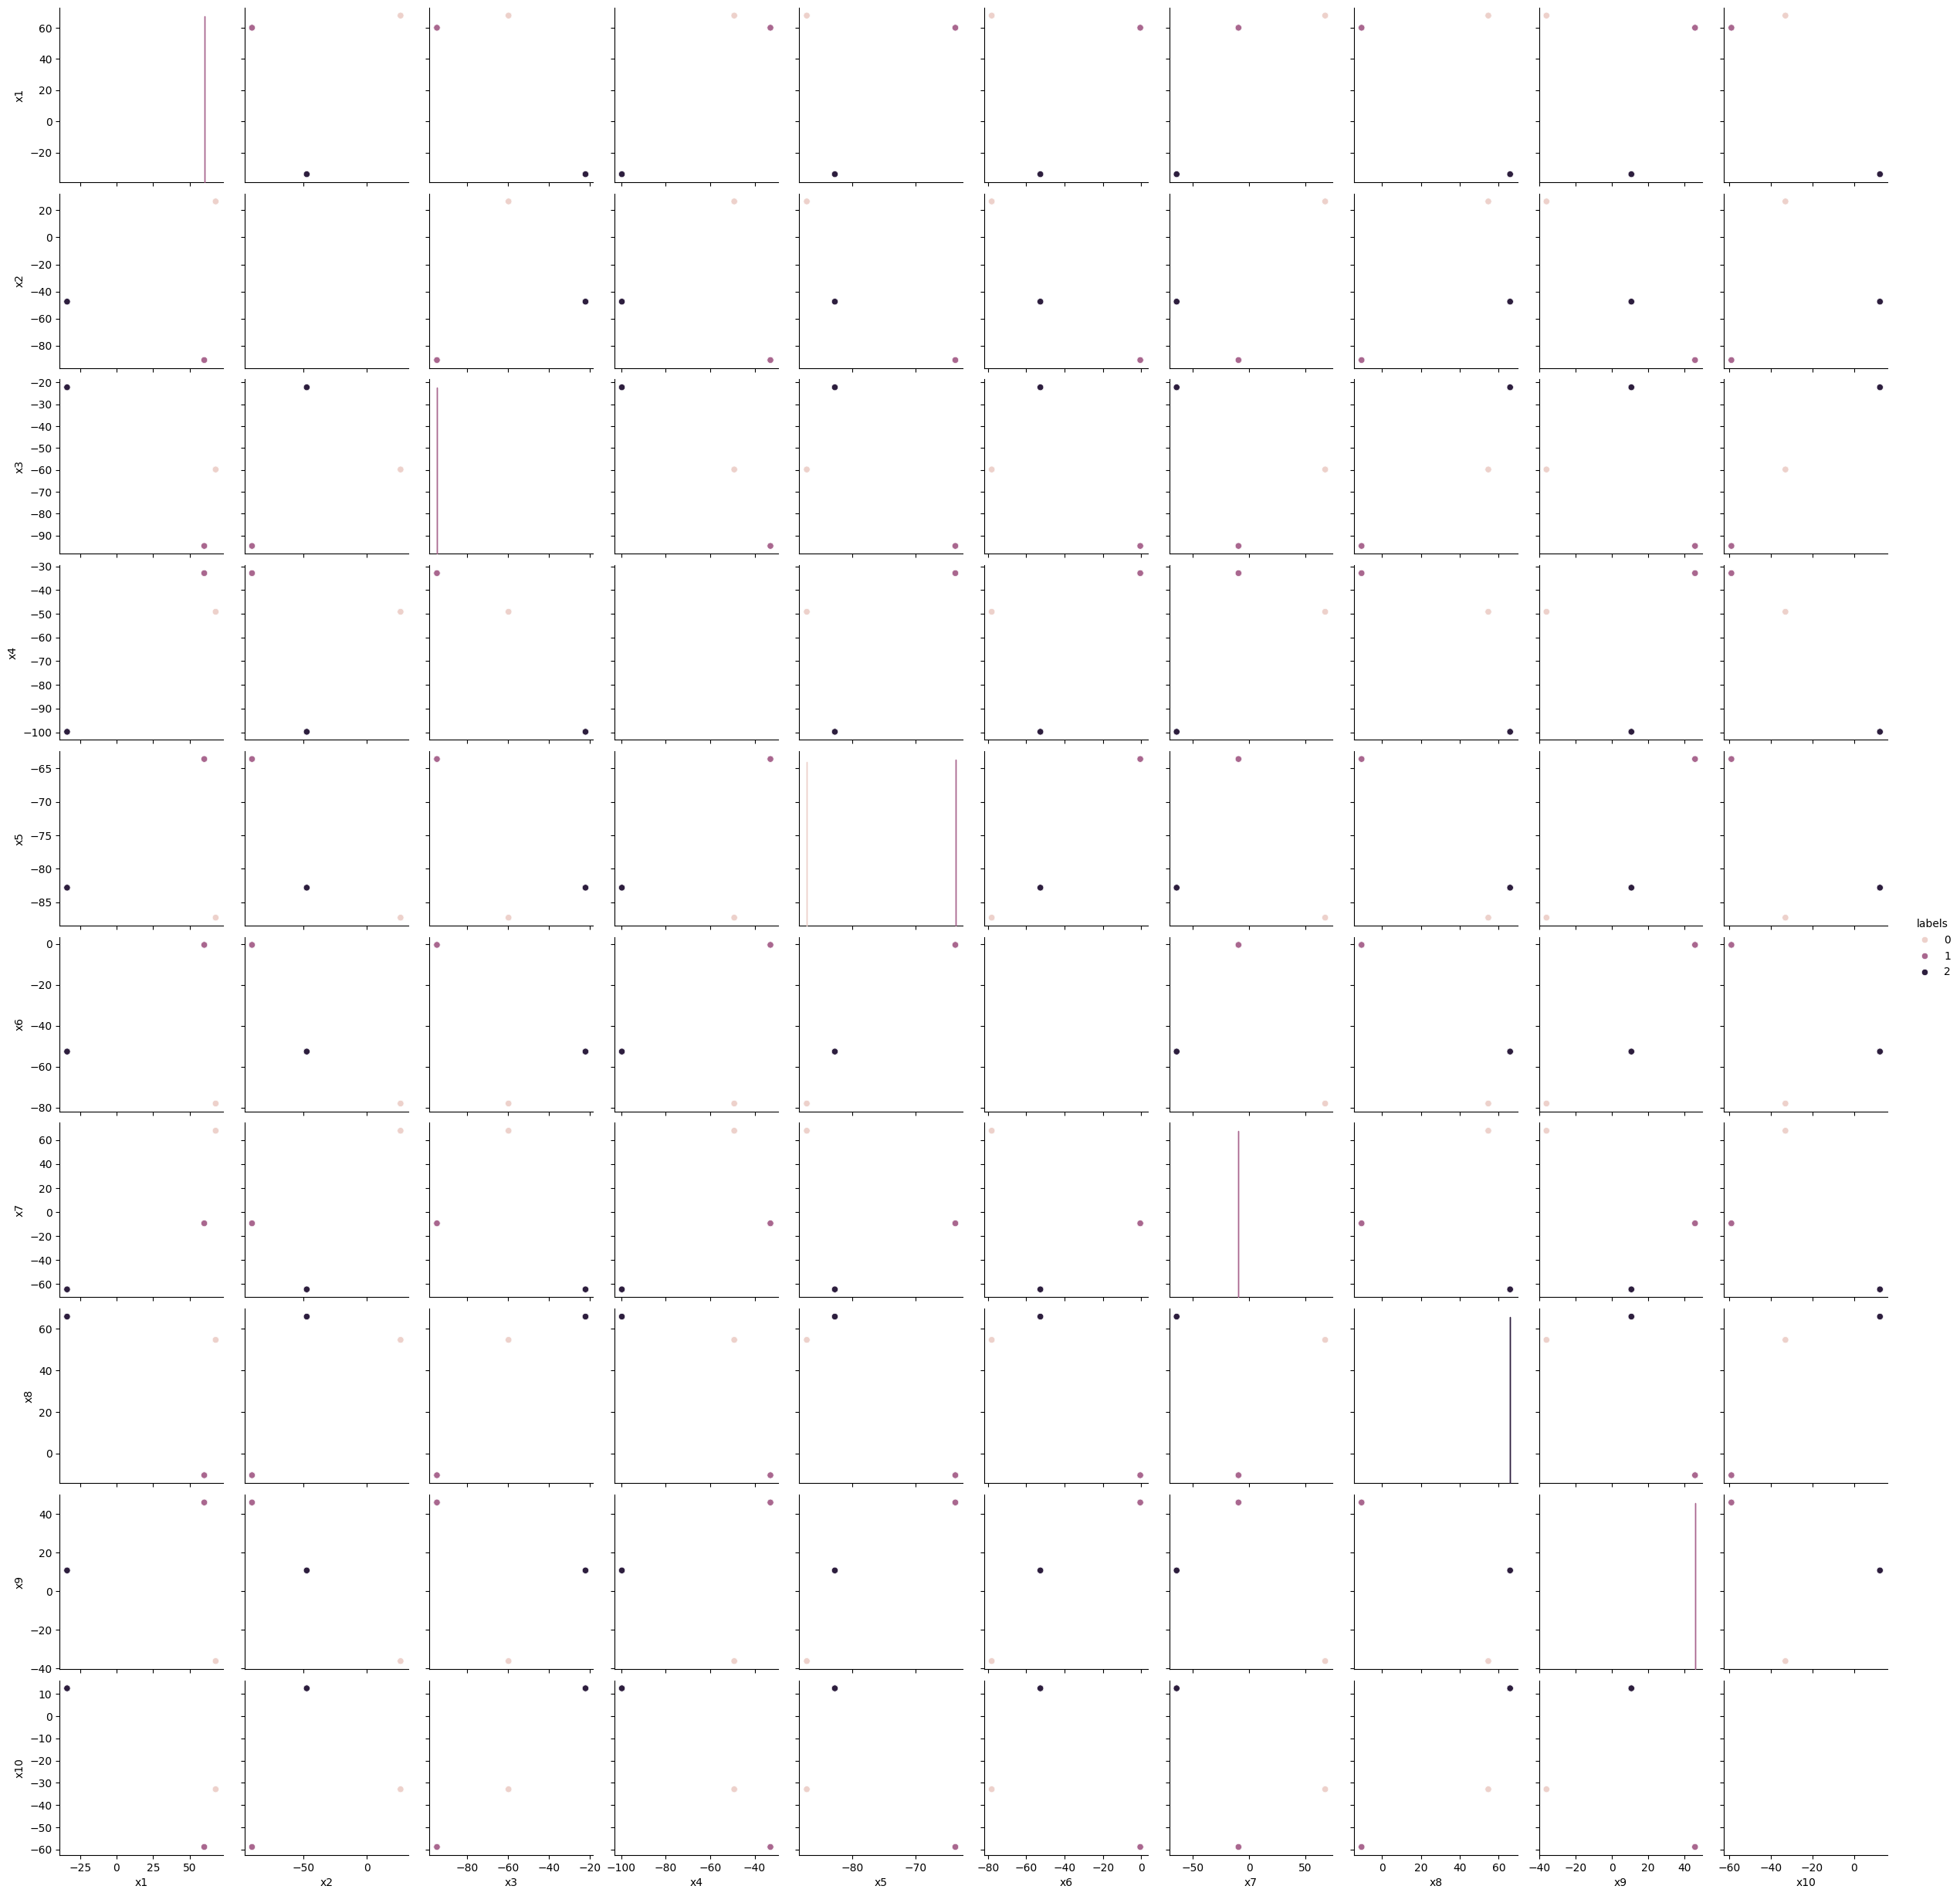

In [494]:
kmeans = KMeans(n_clusters=3).fit(elite_df)


labels = pd.DataFrame(kmeans.labels_) #This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
labeled_df = pd.concat((elite_df,labels),axis=1)
labeled_df = labeled_df.rename({0:'labels'},axis=1)


sns.pairplot(labeled_df,hue='labels')

In [495]:
labeled_df['Constant'] = "Data"

<Axes: xlabel='Constant', ylabel='x2'>

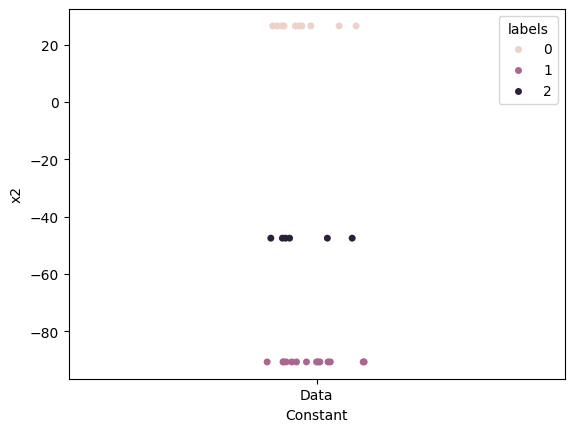

In [498]:
sns.stripplot(x=labeled_df['Constant'],y=labeled_df['x2'],hue=labeled_df['labels'],jitter=True)

<Axes: xlabel='Constant', ylabel='x7'>

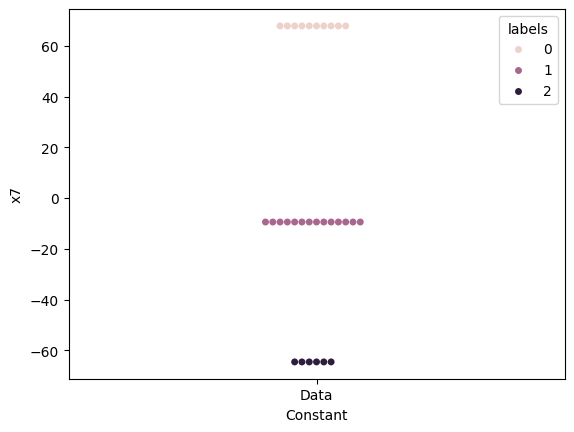

In [503]:
sns.swarmplot(x=labeled_df['Constant'],y=labeled_df['x7'],hue=labeled_df['labels'])